In [2]:
import pandas as pd
import os
import gc
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.preprocessing import MinMaxScaler
import math
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
"""
sns 相关设置
@return:
"""
# 声明使用 Seaborn 样式
sns.set()
# 有五种seaborn的绘图风格，它们分别是：darkgrid, whitegrid, dark, white, ticks。默认的主题是darkgrid。
sns.set_style("whitegrid")
# 有四个预置的环境，按大小从小到大排列分别为：paper, notebook, talk, poster。其中，notebook是默认的。
sns.set_context('talk')
# 中文字体设置-黑体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False
# 解决Seaborn中文显示问题并调整字体大小
sns.set(font='SimHei')

In [3]:
train = pd.read_csv('train.csv')
testA = pd.read_csv('testA.csv')

In [17]:
train['sample'] = 'train'
testA['sample'] = 'test'
data = pd.concat([train, testA], axis=0, ignore_index=True)

In [18]:
data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
data['employmentLength'].replace('< 1 year', '0 years', inplace=True)

def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
    
data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [19]:
data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda s: int(s[-4:]))

In [7]:
cate_features = ['grade', 'subGrade', 'employmentTitle', 'homeOwnership', 'verificationStatus', 'purpose', 'postCode', 'regionCode', \
                 'applicationType', 'initialListStatus', 'title', 'policyCode']
for f in cate_features:
    print(f, '类型数：', data[f].nunique())

grade 类型数： 7
subGrade 类型数： 35
employmentTitle 类型数： 298101
homeOwnership 类型数： 6
verificationStatus 类型数： 3
purpose 类型数： 14
postCode 类型数： 935
regionCode 类型数： 51
applicationType 类型数： 2
initialListStatus 类型数： 2
title 类型数： 47903
policyCode 类型数： 1


In [20]:
# 类型数在2之上，又不是高维稀疏的
data = pd.get_dummies(data, columns=['grade', 'subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'], drop_first=True)

In [21]:
# 高维类别特征需要进行转换
for f in ['employmentTitle', 'postCode', 'title']:
    data[f+'_cnts'] = data.groupby([f])['id'].transform('count')
    data[f+'_rank'] = data.groupby([f])['id'].rank(ascending=False).astype(int)
    del data[f]

In [23]:
from sklearn.model_selection import KFold
# 分离数据集，方便进行交叉验证
X_train = data.loc[data['sample']=='train', :].drop(['id','issueDate','isDefault', 'sample'], axis=1)
X_test = data.loc[data['sample']=='test', :].drop(['id','issueDate','isDefault', 'sample'], axis=1)
y_train = data.loc[data['sample']=='train', 'isDefault']

# 5折交叉验证
folds = 5
seed = 2020
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

In [24]:
"""对训练集数据进行划分，分成训练集和验证集，并进行相应的操作"""
from sklearn.model_selection import train_test_split
import lightgbm as lgb
# 数据集划分
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2)
train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
valid_matrix = lgb.Dataset(X_val, label=y_val)

params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'learning_rate': 0.1,
            'metric': 'auc',
            'min_child_weight': 1e-3,
            'num_leaves': 31,
            'max_depth': -1,
            'reg_lambda': 0,
            'reg_alpha': 0,
            'feature_fraction': 1,
            'bagging_fraction': 1,
            'bagging_freq': 0,
            'seed': 2020,
            'nthread': 8,
            'silent': True,
            'verbose': -1,
}

"""使用训练集数据进行模型训练"""
model = lgb.train(params, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=20000, verbose_eval=1000, early_stopping_rounds=200)

[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[369]	valid_0's auc: 0.731601


未调参前lightgbm单模型在验证集上的AUC：0.7316005357167801


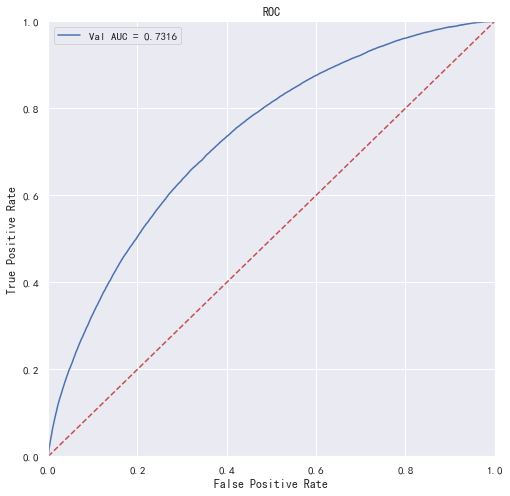

In [25]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

"""预测并计算roc的相关指标"""
val_pre_lgb = model.predict(X_val, num_iteration=model.best_iteration)
fpr, tpr, threshold = metrics.roc_curve(y_val, val_pre_lgb)
roc_auc = metrics.auc(fpr, tpr)
print('未调参前lightgbm单模型在验证集上的AUC：{}'.format(roc_auc))
"""画出roc曲线图"""
plt.figure(figsize=(8, 8))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend(loc='best')
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# 画出对角线
plt.plot([0,1],[0,1],'r--')
plt.show()

In [26]:
import lightgbm as lgb
"""使用lightgbm 5折交叉验证进行建模预测"""
cv_scores = []
for i, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
    print('************************************ {} ************************************'.format(str(i+1)))
    X_train_split, y_train_split, X_val, y_val = X_train.iloc[train_index], y_train[train_index], X_train.iloc[valid_index], y_train[valid_index]
    
    train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
    valid_matrix = lgb.Dataset(X_val, label=y_val)

    params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'learning_rate': 0.1,
                'metric': 'auc',
        
                'min_child_weight': 1e-3,
                'num_leaves': 31,
                'max_depth': -1,
                'reg_lambda': 0,
                'reg_alpha': 0,
                'feature_fraction': 1,
                'bagging_fraction': 1,
                'bagging_freq': 0,
                'seed': 2020,
                'nthread': 8,
                'silent': True,
                'verbose': -1,
    }
    
    model = lgb.train(params, train_set=train_matrix, num_boost_round=20000, valid_sets=valid_matrix, verbose_eval=1000, early_stopping_rounds=200)
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    
    cv_scores.append(roc_auc_score(y_val, val_pred))
    print(cv_scores)

print("lgb_scotrainre_list:{}".format(cv_scores))
print("lgb_score_mean:{}".format(np.mean(cv_scores)))
print("lgb_score_std:{}".format(np.std(cv_scores)))

************************************ 1 ************************************
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[429]	valid_0's auc: 0.730216
[0.7302164635050385]
************************************ 2 ************************************
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[528]	valid_0's auc: 0.726281
[0.7302164635050385, 0.7262811069770285]
************************************ 3 ************************************
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[419]	valid_0's auc: 0.731149
[0.7302164635050385, 0.7262811069770285, 0.7311489916644855]
************************************ 4 ************************************
[LightGBM] [Warning] Unknown parameter: silent
Trai

### 4.5.4 模型调参 

#### 贪心调参

In [27]:
from sklearn.model_selection import cross_val_score

# 调objective
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    """预测并计算roc的相关指标"""
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    best_obj[obj] = score
    
# num_leaves
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    """预测并计算roc的相关指标"""
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    best_leaves[leaves] = score
    
# max_depth
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    """预测并计算roc的相关指标"""
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    best_depth[depth] = score

"""
可依次将模型的参数通过上面的方式进行调整优化，并且通过可视化观察在每一个最优参数下模型的得分情况
"""

NameError: name 'objective' is not defined

In [28]:
"""通过网格搜索确定最优参数"""
from sklearn.model_selection import GridSearchCV

def get_best_cv_params(learning_rate=0.1, n_estimators=581, num_leaves=31, max_depth=-1, bagging_fraction=1.0, 
                       feature_fraction=1.0, bagging_freq=0, min_data_in_leaf=20, min_child_weight=0.001, 
                       min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=None):
    # 设置5折交叉验证
    cv_fold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True, )
    
    model_lgb = lgb.LGBMClassifier(learning_rate=learning_rate,
                                   n_estimators=n_estimators,
                                   num_leaves=num_leaves,
                                   max_depth=max_depth,
                                   bagging_fraction=bagging_fraction,
                                   feature_fraction=feature_fraction,
                                   bagging_freq=bagging_freq,
                                   min_data_in_leaf=min_data_in_leaf,
                                   min_child_weight=min_child_weight,
                                   min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda,
                                   reg_alpha=reg_alpha,
                                   n_jobs= 8
                                  )
    grid_search = GridSearchCV(estimator=model_lgb, 
                               cv=cv_fold,
                               param_grid=param_grid,
                               scoring='roc_auc'
                              )
    grid_search.fit(X_train, y_train)

    print('模型当前最优参数为:{}'.format(grid_search.best_params_))
    print('模型当前最优得分为:{}'.format(grid_search.best_score_))

In [ ]:
"""以下代码未运行，耗时较长，请谨慎运行，且每一步的最优参数需要在下一步进行手动更新，请注意"""

"""
需要注意一下的是，除了获取上面的获取num_boost_round时候用的是原生的lightgbm（因为要用自带的cv）
下面配合GridSearchCV时必须使用sklearn接口的lightgbm。
"""
"""设置n_estimators 为581，调整num_leaves和max_depth，这里选择先粗调再细调"""
lgb_params = {'num_leaves': range(10, 80, 5), 'max_depth': range(3,10,2)}
get_best_cv_params(learning_rate=0.1, n_estimators=581, num_leaves=None, max_depth=None, min_data_in_leaf=20, 
                   min_child_weight=0.001,bagging_fraction=1.0, feature_fraction=1.0, bagging_freq=0, 
                   min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=lgb_params)

"""num_leaves为30，max_depth为7，进一步细调num_leaves和max_depth"""
lgb_params = {'num_leaves': range(25, 35, 1), 'max_depth': range(5,9,1)}
get_best_cv_params(learning_rate=0.1, n_estimators=85, num_leaves=None, max_depth=None, min_data_in_leaf=20, 
                   min_child_weight=0.001,bagging_fraction=1.0, feature_fraction=1.0, bagging_freq=0, 
                   min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=lgb_params)

"""
确定min_data_in_leaf为45，min_child_weight为0.001 ，下面进行bagging_fraction、feature_fraction和bagging_freq的调参
"""
lgb_params = {'bagging_fraction': [i/10 for i in range(5,10,1)], 
              'feature_fraction': [i/10 for i in range(5,10,1)],
              'bagging_freq': range(0,81,10)
             }
get_best_cv_params(learning_rate=0.1, n_estimators=85, num_leaves=29, max_depth=7, min_data_in_leaf=45, 
                   min_child_weight=0.001,bagging_fraction=None, feature_fraction=None, bagging_freq=None, 
                   min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=lgb_params)

"""
确定bagging_fraction为0.4、feature_fraction为0.6、bagging_freq为 ，下面进行reg_lambda、reg_alpha的调参
"""
lgb_params = {'reg_lambda': [0,0.001,0.01,0.03,0.08,0.3,0.5], 'reg_alpha': [0,0.001,0.01,0.03,0.08,0.3,0.5]}
get_best_cv_params(learning_rate=0.1, n_estimators=85, num_leaves=29, max_depth=7, min_data_in_leaf=45, 
                   min_child_weight=0.001,bagging_fraction=0.9, feature_fraction=0.9, bagging_freq=40, 
                   min_split_gain=0, reg_lambda=None, reg_alpha=None, param_grid=lgb_params)

"""
确定reg_lambda、reg_alpha都为0，下面进行min_split_gain的调参
"""
lgb_params = {'min_split_gain': [i/10 for i in range(0,11,1)]}
get_best_cv_params(learning_rate=0.1, n_estimators=85, num_leaves=29, max_depth=7, min_data_in_leaf=45, 
                   min_child_weight=0.001,bagging_fraction=0.9, feature_fraction=0.9, bagging_freq=40, 
                   min_split_gain=None, reg_lambda=0, reg_alpha=0, param_grid=lgb_params)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsampl

<div class="alert alert-block alert-danger">
大概知道了调参的三个方法，对于贪心调参，没有objective列表。需要填坑 </div>
